In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.metrics import silhouette_score
import pandas as pd
import plotly.express as px
from sklearn.base import TransformerMixin, BaseEstimator
import category_encoders as ce
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
#from sklearn.ensemble import StackingRegressor
#from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, f_regression
import optuna
from functions import *
import logging
import warnings 
import pickle

warnings.filterwarnings("ignore")

In [2]:
fmt = '%(asctime)s %(levelname)s %(lineno)s %(message)s'
logging.basicConfig(level='INFO', format=fmt, filename='log.log', filemode='a') 
logger = logging.getLogger('logit')

In [3]:
df_cottage = pd.read_csv('data/country_houses_2.csv').drop(['Unnamed: 0'], axis=1)
print(df_cottage.shape)
print(f"Duplicates found: {df_cottage[df_cottage.duplicated].shape[0]}")
df_cottage.head(3)


(13135, 52)
Duplicates found: 0


,index,Тип объекта,Площадь участка,Ширина застройки,Длина застройки,Год постройки,Материал стен,Материал крыши,Ремонт,Отопление,...,Элитный коттедж,Камин,Хозпостройки,Строительные материалы,Направление,Мебель,Баня,Пруд на участке,Новостройка,Аукцион
0,3032596,['Дом'],"['11', 'соток']","['5', 'м']","['7', 'м']",['2008'],"['Брус', 'оцилиндрованный']",['Шифер'],"['Не', 'достроен']",['Печное'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3237237,['Дом'],"['12', 'соток']",NaN,NaN,NaN,['Блочный'],['Шифер'],NaN,"['На', 'газу']",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3201241,['Дом'],"['13', 'соток']",NaN,NaN,['2004'],"['Дерево,', 'обложено', 'кирпичом']",['Шифер'],NaN,"['На', 'газу']",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df_dacha = pd.read_csv('data/country_houses.csv').drop(['Unnamed: 0'], axis=1)
print(df_dacha.shape)
print(f"Duplicates found: {df_dacha[df_dacha.duplicated].shape[0]}")
df_dacha.head(3)

(3052, 52)
Duplicates found: 0


,index,Тип объекта,Площадь участка,Площадь общая,Площадь жилая,Уровней в доме,Год постройки,Процент готовности,Материал стен,Материал крыши,...,Камин,Строительные материалы,Район города,Беседка,Микрорайон,Новостройка,Бассейн,Элитный коттедж,Пруд на участке,Аукцион
0,3289189,['Дача'],"['10.38', 'соток']","['16.7', 'м²']","['12', 'м²']",['1'],['2000'],['100'],['Дерево'],['Шифер'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3045903,['Дача'],"['7.55', 'соток']","['60.2', 'м²']","['43.1', 'м²']",['2'],['1991'],NaN,"['Блок', 'газосиликатный']",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3292051,['Дача'],"['5', 'соток']","['80.8', 'м²']","['60', 'м²']",['3'],NaN,['100'],"['Красный', 'кирпич']",['Шифер'],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
set(df_cottage.columns).symmetric_difference(set(df_dacha.columns))

set()

In [6]:
df = pd.concat([df_dacha, df_cottage], axis=0)
df.shape

(16187, 52)

In [7]:
print(f"nan in price column: {df['Цена'].isna().sum()}")
df = df[df['Цена'].notna()]
df.shape

nan in price column: 749


(15438, 52)

In [8]:
color_scale = [(0, 'orange'), (1,'red')]

fig = px.scatter_mapbox(df, 
                        lat=df['Координаты'].dropna().apply(lambda x: float(re.findall(r"\'(\d{2}\.\d{1,}).", str(x))[0])), 
                        lon=df['Координаты'].dropna().apply(lambda x: float(re.findall(r"\'(\d{2}\.\d{1,}).", str(x))[1])),  
                        #hover_name="Address", 
                        #hover_data=["Address", "Listed"],
                        #color="Listed",
                        color_continuous_scale=color_scale,
                        #size="Listed",
                        zoom=8, 
                        height=800,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [9]:
class NUM_Transformer(TransformerMixin, BaseEstimator):
    '''Transform numeric features'''

    def __init__(self):
        pass


    def fit(self, X, y=None):
        '''
        '''
        return self


    def transform(self,X):
        ''''''
        X['land_area'] = X['Площадь участка'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
        X['house_area'] = X['Площадь общая'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
        X['house_levels'] = X['Уровней в доме'].apply(lambda x: int(re.findall(r"\d{1}", x)[0]) if x is not np.nan else x)
        X['house_year'] = X['Год постройки'].apply(lambda x: int(re.findall(r"\d{4}", x)[0]) if x is not np.nan else x)
        X['house_readiness'] = X['Процент готовности'].apply(lambda x: int(re.findall(r"\d{1,}", x)[0]) if x is not np.nan else x)
        #X['house_readiness'] = pd.cut(X.house_readiness.fillna(np.nan), [0,20,40,60,80,99,100, np.nan], labels = ['<20','20-40','40-60','60-80','80-99','100', 'unknown'])
        X['house_coordinates'] = X.loc[:,'Координаты'].apply(
            lambda x: (float(re.findall(r"\d{2}\.\d{1,}", x)[0]),float(re.findall(r"\d{2}\.\d{1,}", x)[1])) if x is not np.nan else x)
        X['price'] = X['Цена'].apply(
            lambda x: int(re.findall(r"(\d{1,}).", x.replace('\xa0',''))[0]) if x is not np.nan else x)            
            #lambda x: float(x.split()[0] + x.split()[1]))
        X['liv_house_area'] = X['Площадь жилая'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
        X['kitchen_area'] = X['Площадь кухни'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
        X['house_width'] = X['Ширина застройки'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
        X['house_length'] = X['Длина застройки'].apply(lambda x: float(re.findall(r"\d+\.*\d*", x)[0]) if x is not np.nan else x)
        
        X.drop(['Площадь участка', 'Площадь общая', 'Уровней в доме', 'Год постройки', 'Процент готовности', 'Координаты', 'Цена',
              'Площадь жилая', 'Площадь кухни', 'Ширина застройки', 'Длина застройки', 'kitchen_area', 'liv_house_area','house_length','house_width'], axis=1, inplace=True)

        X = X.fillna({
            'house_readiness': X['house_readiness'].median(),
            'house_area': X['house_area'].median(), 
            'land_area': X['land_area'].median(),
            'house_coordinates': X['house_coordinates'].fillna(df.groupby('Населенный пункт')['house_coordinates'].transform(
                lambda x: str(x.value_counts().index[0]) if len(x.value_counts().index)>0 else np.nan))
        })

        X = X[X['house_coordinates'].notna()]        
        X = X[(X['price']<400000) & (X['price']>1000)]

        print(f"DF shape after NUM_Transformer {X.shape}")

        return X
    

num_treat = NUM_Transformer()
df = num_treat.transform(df)

DF shape after NUM_Transformer (13030, 48)


In [10]:
df.columns

Index(['index', 'Тип объекта', 'Материал стен', 'Материал крыши', 'Отопление',
       'Канализация', 'Электроснабжение', 'Вода', 'Телефон', 'Условия продажи',
       'Номер договора', 'Область', 'Район', 'Населенный пункт', 'Номер дома',
       'Сельсовет', 'Газ', 'Баня', 'Гараж', 'Статус земли', 'Сад',
       'Хозпостройки', 'Возможен торг', 'Рядом лес', 'Водоем',
       'Ландшафтный дизайн', 'Улица', 'Теплица', 'Мебель', 'Направление',
       'Ремонт', 'Камин', 'Строительные материалы', 'Район города', 'Беседка',
       'Микрорайон', 'Новостройка', 'Бассейн', 'Элитный коттедж',
       'Пруд на участке', 'Аукцион', 'land_area', 'house_area', 'house_levels',
       'house_year', 'house_readiness', 'house_coordinates', 'price'],
      dtype='object')

In [11]:
num_features = ['land_area', 'house_area', 'house_readiness',  'price',]
cat_features = [item for item in df.columns if item not in num_features]


In [12]:
categories = df[cat_features].nunique().sort_values(ascending=False)
display(categories)

index                     13029
house_coordinates         10807
Номер договора             8280
Населенный пункт           4425
Улица                      2040
Сельсовет                   788
Направление                 761
Номер дома                  399
Микрорайон                  148
house_year                  121
Район                       118
Материал стен                22
Район города                 14
Материал крыши               13
Вода                         11
Отопление                    10
Ремонт                        7
Статус земли                  7
Область                       6
Условия продажи               6
Канализация                   5
Электроснабжение              5
Тип объекта                   5
house_levels                  5
Газ                           5
Телефон                       3
Пруд на участке               1
Элитный коттедж               1
Бассейн                       1
Аукцион                       1
Новостройка                   1
Беседка 

In [13]:
df.isna().sum().sort_values(ascending=False)

Аукцион                   12954
Бассейн                   12918
Элитный коттедж           12855
Пруд на участке           12705
Новостройка               12542
Строительные материалы    12525
Камин                     12204
Теплица                   11844
Беседка                   11833
Микрорайон                11793
Район города              11747
Ремонт                    11327
Телефон                   11145
Баня                      11127
Мебель                    10436
Направление               10363
Гараж                     10179
Сад                        9511
Водоем                     8903
Ландшафтный дизайн         8855
Номер дома                 8777
Рядом лес                  8247
Возможен торг              8220
Хозпостройки               7714
Сельсовет                  6283
Улица                      6096
Номер договора             4524
Газ                        4360
house_year                 3646
Канализация                3465
Материал крыши             3289
house_le

In [14]:
df.drop(['Аукцион', 'index', 'Номер договора', 'Улица', 'Номер дома', 'Микрорайон', 'Район города', 'Возможен торг'], axis=1, inplace=True)
cat_features = [item for item in df.columns if item not in num_features]

categories = df.loc[:, cat_features].nunique().sort_values(ascending=False) 
categories


house_coordinates         10807
Населенный пункт           4425
Сельсовет                   788
Направление                 761
house_year                  121
Район                       118
Материал стен                22
Материал крыши               13
Вода                         11
Отопление                    10
Статус земли                  7
Ремонт                        7
Условия продажи               6
Область                       6
house_levels                  5
Тип объекта                   5
Канализация                   5
Электроснабжение              5
Газ                           5
Телефон                       3
Гараж                         1
Строительные материалы        1
Пруд на участке               1
Элитный коттедж               1
Бассейн                       1
Новостройка                   1
Беседка                       1
Камин                         1
Сад                           1
Мебель                        1
Теплица                       1
Ландшафт

### Binary categories

In [15]:
bin_categories = categories[categories<=3]
print(bin_categories)

Телефон                   3
Гараж                     1
Строительные материалы    1
Пруд на участке           1
Элитный коттедж           1
Бассейн                   1
Новостройка               1
Беседка                   1
Камин                     1
Сад                       1
Мебель                    1
Теплица                   1
Ландшафтный дизайн        1
Водоем                    1
Рядом лес                 1
Баня                      1
Хозпостройки              1
dtype: int64


In [16]:
display(df['Беседка'].value_counts())
display(df['Камин'].value_counts())
display(df['Телефон'].value_counts())

Беседка
1.0    1197
Name: count, dtype: int64

Камин
['Да']    826
Name: count, dtype: int64

Телефон
['Есть']             1871
['2', 'телефона']      11
['3', 'телефона']       3
Name: count, dtype: int64

In [17]:
class BIN_Transformer(TransformerMixin, BaseEstimator):
    '''Transform binary categories'''

    def __init__(self, bin_categories):
        self.categories = bin_categories
        
    def fit(self, X, y=None):
        return self

    def transform(self,X):
        ''''''
        for item in self.categories.index:
            X[item] = X[item].apply(lambda x: 0 if pd.isna(x) else 1)     
        
        print(f"DF shape after BIN_Transformer {X.shape}")

        return X
    

bin_treat = BIN_Transformer(bin_categories)
df = bin_treat.transform(df)

DF shape after BIN_Transformer (13030, 40)


### Multi options categories 

In [18]:
multi_categories = categories[categories>3]
display(multi_categories)


house_coordinates    10807
Населенный пункт      4425
Сельсовет              788
Направление            761
house_year             121
Район                  118
Материал стен           22
Материал крыши          13
Вода                    11
Отопление               10
Статус земли             7
Ремонт                   7
Условия продажи          6
Область                  6
house_levels             5
Тип объекта              5
Канализация              5
Электроснабжение         5
Газ                      5
dtype: int64

In [19]:
df[multi_categories.index].isna().sum().sort_values(ascending=False) #/ df.shape[0]

Ремонт               11327
Направление          10363
Сельсовет             6283
Газ                   4360
house_year            3646
Канализация           3465
Материал крыши        3289
house_levels          2805
Отопление             2637
Электроснабжение      2026
Условия продажи       1950
Вода                  1930
Статус земли          1787
Материал стен         1643
Район                   96
Населенный пункт         0
Область                  0
Тип объекта              0
house_coordinates        0
dtype: int64

In [20]:
# fillna
fill_na_net = ['Электроснабжение', 'Вода', 'Отопление', 'Канализация', 'Газ']
fill_na_mode = ['Материал крыши', 'house_levels', 'Статус земли', 'Материал стен', 'Тип объекта', 'Условия продажи', 'Ремонт']
fill_na_manage = ['Направление', 'Сельсовет', 'Район', 'Область', 'house_year', 'Населенный пункт']


### Multi options categories. Fill NAN with 'net'

In [21]:
fill_na_net

['Электроснабжение', 'Вода', 'Отопление', 'Канализация', 'Газ']

In [22]:
print(stat_compare(df,'Канализация', "['С/у', 'на', 'улице']", "['Нет']"))
print(stat_compare(df,'Канализация', "['Местная']", "['Центральная']"))

print(stat_compare(df,'Электроснабжение', "['Рядом']", "['Нет']"))
print(stat_compare(df,'Электроснабжение', "['Есть']", "['220В']"))

print(stat_compare(df,'Вода', "['Рядом', 'колодец']", "['Рядом']"))
print(stat_compare(df,'Вода', "['Рядом', 'водопровод']", "['Рядом']"))
print(stat_compare(df,'Вода', "['Нет']", "['Рядом']"))

print(stat_compare(df,'Отопление', "['На', 'газу']", "['Паровое']"))
print(stat_compare(df,'Отопление', "['Паровое', 'на', 'твёрдом', 'топливе']", "['Паровое']"))
print(stat_compare(df,'Отопление', "['Паровое', 'на', 'жидком', 'топливе']", "['Паровое']"))

КАНАЛИЗАЦИЯ ['С/у', 'на', 'улице'] (1), ['Нет'] (1): EQUAL --> ['С/у', 'на', 'улице']
КАНАЛИЗАЦИЯ ['Местная'] (1), ['Центральная'] (1): not equal
ЭЛЕКТРОСНАБЖЕНИЕ ['Рядом'] (1), ['Нет'] (1): not equal
ЭЛЕКТРОСНАБЖЕНИЕ ['Есть'] (1), ['220В'] (1): not equal
ВОДА ['Рядом', 'колодец'] (1), ['Рядом'] (1): not equal
ВОДА ['Рядом', 'водопровод'] (1), ['Рядом'] (1): not equal
ВОДА ['Нет'] (1), ['Рядом'] (1): not equal
ОТОПЛЕНИЕ ['На', 'газу'] (1), ['Паровое'] (1): not equal
ОТОПЛЕНИЕ ['Паровое', 'на', 'твёрдом', 'топливе'] (1), ['Паровое'] (1): not equal
ОТОПЛЕНИЕ ['Паровое', 'на', 'жидком', 'топливе'] (1), ['Паровое'] (1): not equal


In [23]:
class CAT_1_Transformer(TransformerMixin, BaseEstimator):
    '''Transform categories with multiple values, supposed to be fillna with "no" '''

    def __init__(self, fillna_cats):
        self.categories = fillna_cats
     
    def fit(self, X, y=None):
        ''''''
        return self

    def transform(self,X):
        ''''''
        X['Газ'] = X['Газ'].map({
            "['Рядом']":'рядом', 
            "['Есть']":'есть', 
            "['Нет']":'нет',
            "['Баллон']":'нет',
            "['Магистральный']":'есть',            
            }) 

        X['Канализация'] = X['Канализация'].map({
            "['С/у', 'на', 'улице']":'с/у наружн.', 
            "['Местная']":'местная', 
            "['Есть']":'есть', 
            "['Центральная']":'центральн.', 
            "['Нет']":'нет',
            })

        X['Электроснабжение'] = X['Электроснабжение'].map({
            "['Есть']":'есть', 
            "['220В']":'есть', 
            "['Рядом']":'рядом', 
            "['380В']":'380В', 
            "['Нет']":'нет',
            })

        X['Отопление'] = X['Отопление'].map({
            "['На', 'газу']":'паровое г.',
            "['Печное']":'печь', 
            "['Электрическое']":'электрич.',
            "['Нет']":'нет', 
            "['Центральное']":'центральн.',
            "['Паровое', 'на', 'твёрдом', 'топливе']":'паровое т.', 
            "['Паровое', 'на', 'газу']":'паровое г.', 
            "['Паровое', 'на', 'жидком', 'топливе']":'паровое ж.',
            "['Паровое']":'паровое',
            "['Альтернативные', 'источники']":'альтерн.',             
            })
        
        X['Вода'] = X['Вода'].map({
            "['Центральный', 'водопровод']":'водопровод',
            "['Скважина']":'скважина', 
            "['Колодец']":'колодец',
            "['Сезонная']":'сезонная', 
            "['Горячая']":'горячая',
            "['Холодная']":'холодная',
            "['Рядом']":'рядом',
            "['Рядом', 'колодец']":'рядом колодец',
            "['Нет']":'нет',
            "['Рядом', 'водопровод']":'рядом',
            "['Водопровод']":'водопровод'
            })

 
        X[self.categories] = X[self.categories].fillna('нет')

        print(f"DF shape after CAT_1_Transformer {X.shape}")

        return X
    

cat_1_treat = CAT_1_Transformer(fill_na_net)
df = cat_1_treat.transform(df)

DF shape after CAT_1_Transformer (13030, 40)


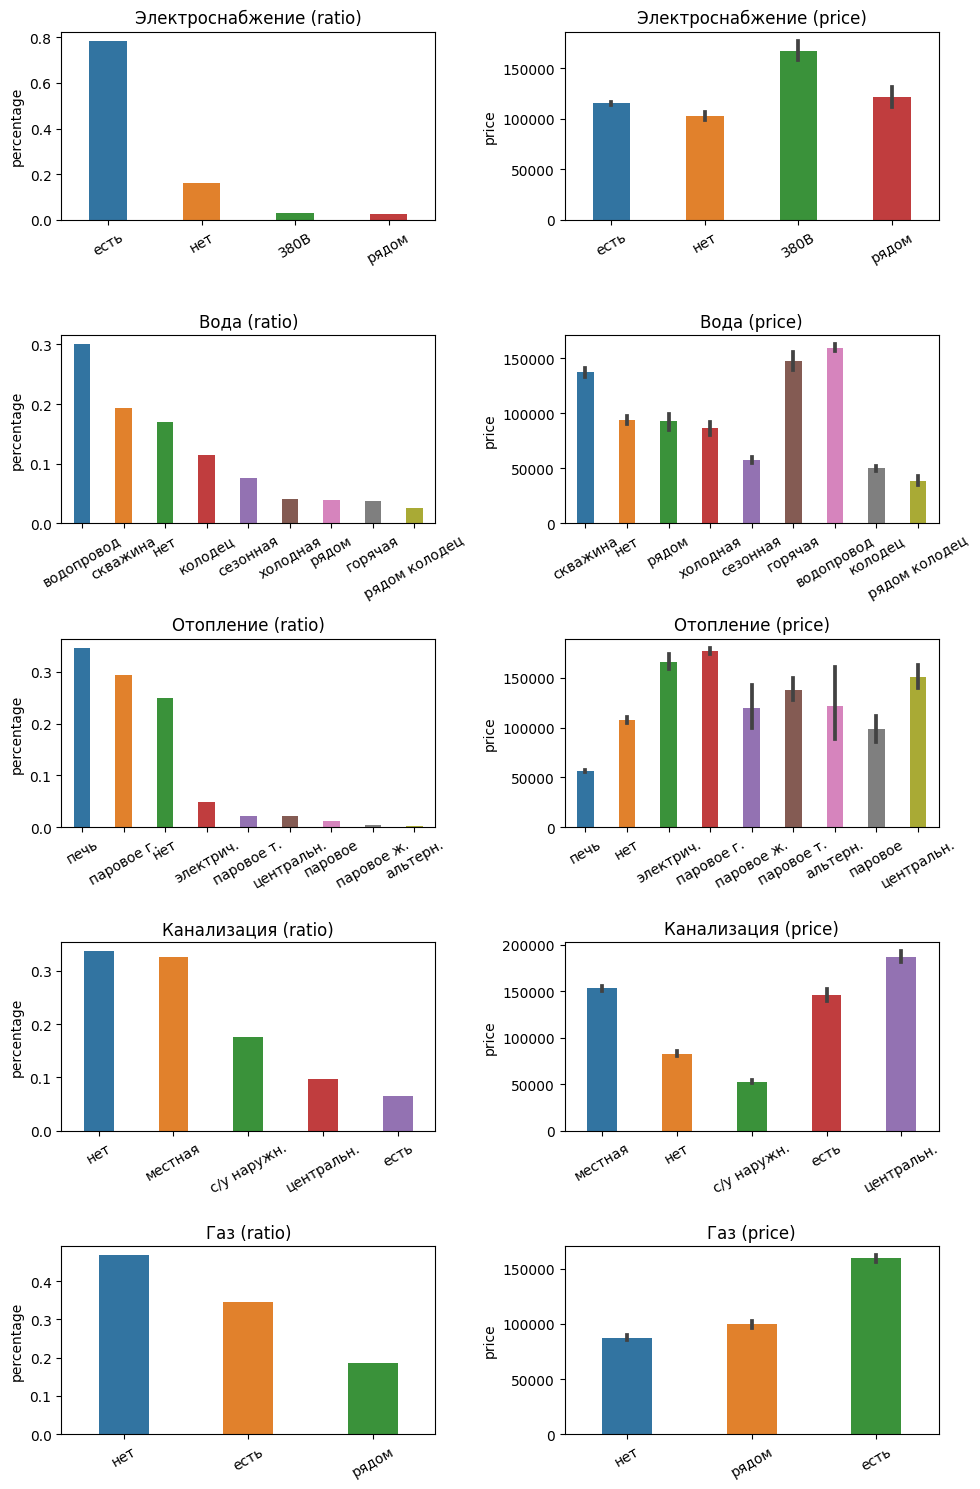

In [24]:
draw_categories(df,fill_na_net)

### Multi options categories. Fill NAN with mode-value

In [25]:
fill_na_mode

['Материал крыши',
 'house_levels',
 'Статус земли',
 'Материал стен',
 'Тип объекта',
 'Условия продажи',
 'Ремонт']

In [26]:
print(stat_compare(df,'Материал стен', "['Блок', 'газосиликатный']", "['Блочный']"))
print(stat_compare(df,'Материал стен', "['Силикатные', 'блоки']", "['Блочный']"))
print(stat_compare(df,'Материал стен', "['Блок', 'газосиликатный']", "['Силикатные', 'блоки']"))
print(stat_compare(df,'Материал стен', "['Белый', 'кирпич']", "['Кирпичный']"))
print(stat_compare(df,'Материал стен', "['Белый', 'кирпич']", "['Красный', 'кирпич']"))
print(stat_compare(df,'Материал стен', "['Красный', 'кирпич']", "['Кирпичный']"))
print(stat_compare(df,'Материал стен', "['Бревенчатый']", "['Сруб']"))

print(stat_compare(df,'Материал крыши', "['Металло-черепица']", "['Металл']"))
print(stat_compare(df,'Материал крыши', "['Ондулин']", "['Евро-шифер']"))
print(stat_compare(df,'Материал крыши', "['Мягкая', 'черепица']", "['Битумная', 'черепица']"))
print(stat_compare(df,'Материал крыши', "['Жесть']", "['Металл']"))
print(stat_compare(df,'Материал крыши', "['Рубероид']", "['Гидроизоляция']"))

print(stat_compare(df,'Тип объекта', "['Таунхаус']", "['Коттедж']"))

print(stat_compare(df,'Ремонт', "['Евроотделка,', 'отделка', 'деревом']", "['Евроотделка']"))
print(stat_compare(df,'Ремонт', "['Не', 'достроен,', 'отделка', 'деревом']", "['Не', 'достроен']"))


МАТЕРИАЛ СТЕН ['Блок', 'газосиликатный'] (1), ['Блочный'] (1): not equal
МАТЕРИАЛ СТЕН ['Силикатные', 'блоки'] (1), ['Блочный'] (1): not equal
МАТЕРИАЛ СТЕН ['Блок', 'газосиликатный'] (1), ['Силикатные', 'блоки'] (1): EQUAL --> ['Блок', 'газосиликатный']
МАТЕРИАЛ СТЕН ['Белый', 'кирпич'] (1), ['Кирпичный'] (1): not equal
МАТЕРИАЛ СТЕН ['Белый', 'кирпич'] (1), ['Красный', 'кирпич'] (1): not equal
МАТЕРИАЛ СТЕН ['Красный', 'кирпич'] (1), ['Кирпичный'] (1): EQUAL --> ['Кирпичный']
МАТЕРИАЛ СТЕН ['Бревенчатый'] (1), ['Сруб'] (1): not equal
МАТЕРИАЛ КРЫШИ ['Металло-черепица'] (1), ['Металл'] (1): not equal
МАТЕРИАЛ КРЫШИ ['Ондулин'] (1), ['Евро-шифер'] (1): EQUAL --> ['Ондулин']
МАТЕРИАЛ КРЫШИ ['Мягкая', 'черепица'] (1), ['Битумная', 'черепица'] (1): EQUAL --> ['Мягкая', 'черепица']
МАТЕРИАЛ КРЫШИ ['Жесть'] (1), ['Металл'] (1): not equal
МАТЕРИАЛ КРЫШИ ['Рубероид'] (1), ['Гидроизоляция'] (0): not equal
ТИП ОБЪЕКТА ['Таунхаус'] (1), ['Коттедж'] (1): not equal
РЕМОНТ ['Евроотделка,', 'отделка

In [27]:
class CAT_2_Transformer(TransformerMixin, BaseEstimator):
    '''Transform categories with multiple values, supposed to be fillna with mode-value '''

    def __init__(self, fillna_cats):
        self.categories = fillna_cats
     
    def fit(self, X, y=None):
        ''''''
        return self

    def transform(self,X):
        ''''''

        X['Тип объекта'] = X['Тип объекта'].map({
            "['Дом']":'дом',
            "['Дача']":'дача',
            "['Коттедж']":'коттедж', 
            "['Полдома']":'полдома',
            "['Таунхаус']":'таунхаус', 
            })

        X['Материал стен'] = X['Материал стен'].map({
            "['Дерево']":'дерево', 
            "['Кирпичный']":'кирпич', 
            "['Блок', 'газосиликатный']":'блок г/с', 
            "['Блочный']":'блок',
            "['Дерево,', 'обложено', 'кирпичом']":'дер., кирпич',
            "['Сруб']":'сруб',
            "['Брус', 'профилированный']":'брус профил.',
            "['Сборно-щитовой']":'сб-щитовой',
            "['Шлакобетон']":'шлакобетон',            
            "['Керамзитбетон']":'керамзитобетон',
            "['Каркасный', 'деревянный']":'каркасн. дер.',
            "['Белый', 'кирпич']":'кирпич бел.',
            "['Бревенчатый']":'сруб',
            "['Силикатные', 'блоки']":'блок г/с',
            "['Красный', 'кирпич']":'кирпич',
            "['Панельный']":'панельн.',
            "['Брус', 'оцилиндрованный']":'брус оцил.',
            "['Каркасно-засыпной']":'другой',
            "['Облицовочный', 'кирпич']":'другой',
            "['Брус', 'клееный']":'другой',
            "['Монолитно-каркасный']":'другой',
            "['Блок-комнаты']":'другой'
            })

        X['Материал крыши'] = X['Материал крыши'].map({
            "['Шифер']":'шифер',
            "['Металло-черепица']":'черепица мет.', 
            "['Мягкая', 'черепица']":'черепица мяг.',
            "['Черепица']":'черепица',
            "['Ондулин']":'ондулин', 
            "['Металл']":'металл',
            "['Жесть']":'жесть',
            "['Евро-шифер']":'ондулин',
            "['Битумная', 'черепица']":'черепица мяг.',
            "['Рубероид']":'другой',
            "['Гидроизоляция']":'другой',
            "['Доски']":'другой',
            "['Природные', 'материалы']":'другой'
            })

        X['Статус земли'] = X['Статус земли'].map({
            "['Частная', 'собственность']":'частная',
            "['Пожизненно', 'наследуемое', 'владение']":'пожизн. насл.',
            "['Частная']":'частная', 
            "['Аренда']":'аренда',
            "['Пожизненноe', 'наследуемое', 'владение']":'пожизн. насл.', 
            "['Другое']":'другое', 
            "['Пользование']":'другое'
            })
        
        X['Ремонт'] = X['Ремонт'].map({
            "['Отделка', 'деревом']":'отделка дер.', 
            "['Не', 'достроен']":'не достроен',
            "['Евроотделка']":'евроотделка',
            "['Евроотделка,', 'отделка', 'деревом']":'евроотделка',
            "['Не', 'достроен,', 'отделка', 'деревом']":'не достроен',
            "['Евроотделка,', 'не', 'достроен']": 'не достроен',
            "['Евроотделка,', 'не', 'достроен,', 'отделка', 'деревом']":'не достроен'
            })

        X[self.categories] = X[self.categories].fillna(X.mode().iloc[0])
        X.drop(['Условия продажи'], axis=1, inplace=True)
        #X = X[X['Тип объекта']=='дача']
        
        print(f"DF shape after CAT_2_Transformer {X.shape}")

        return X
    

cat_2_treat = CAT_2_Transformer(fill_na_mode)
df = cat_2_treat.transform(df)

DF shape after CAT_2_Transformer (13030, 39)


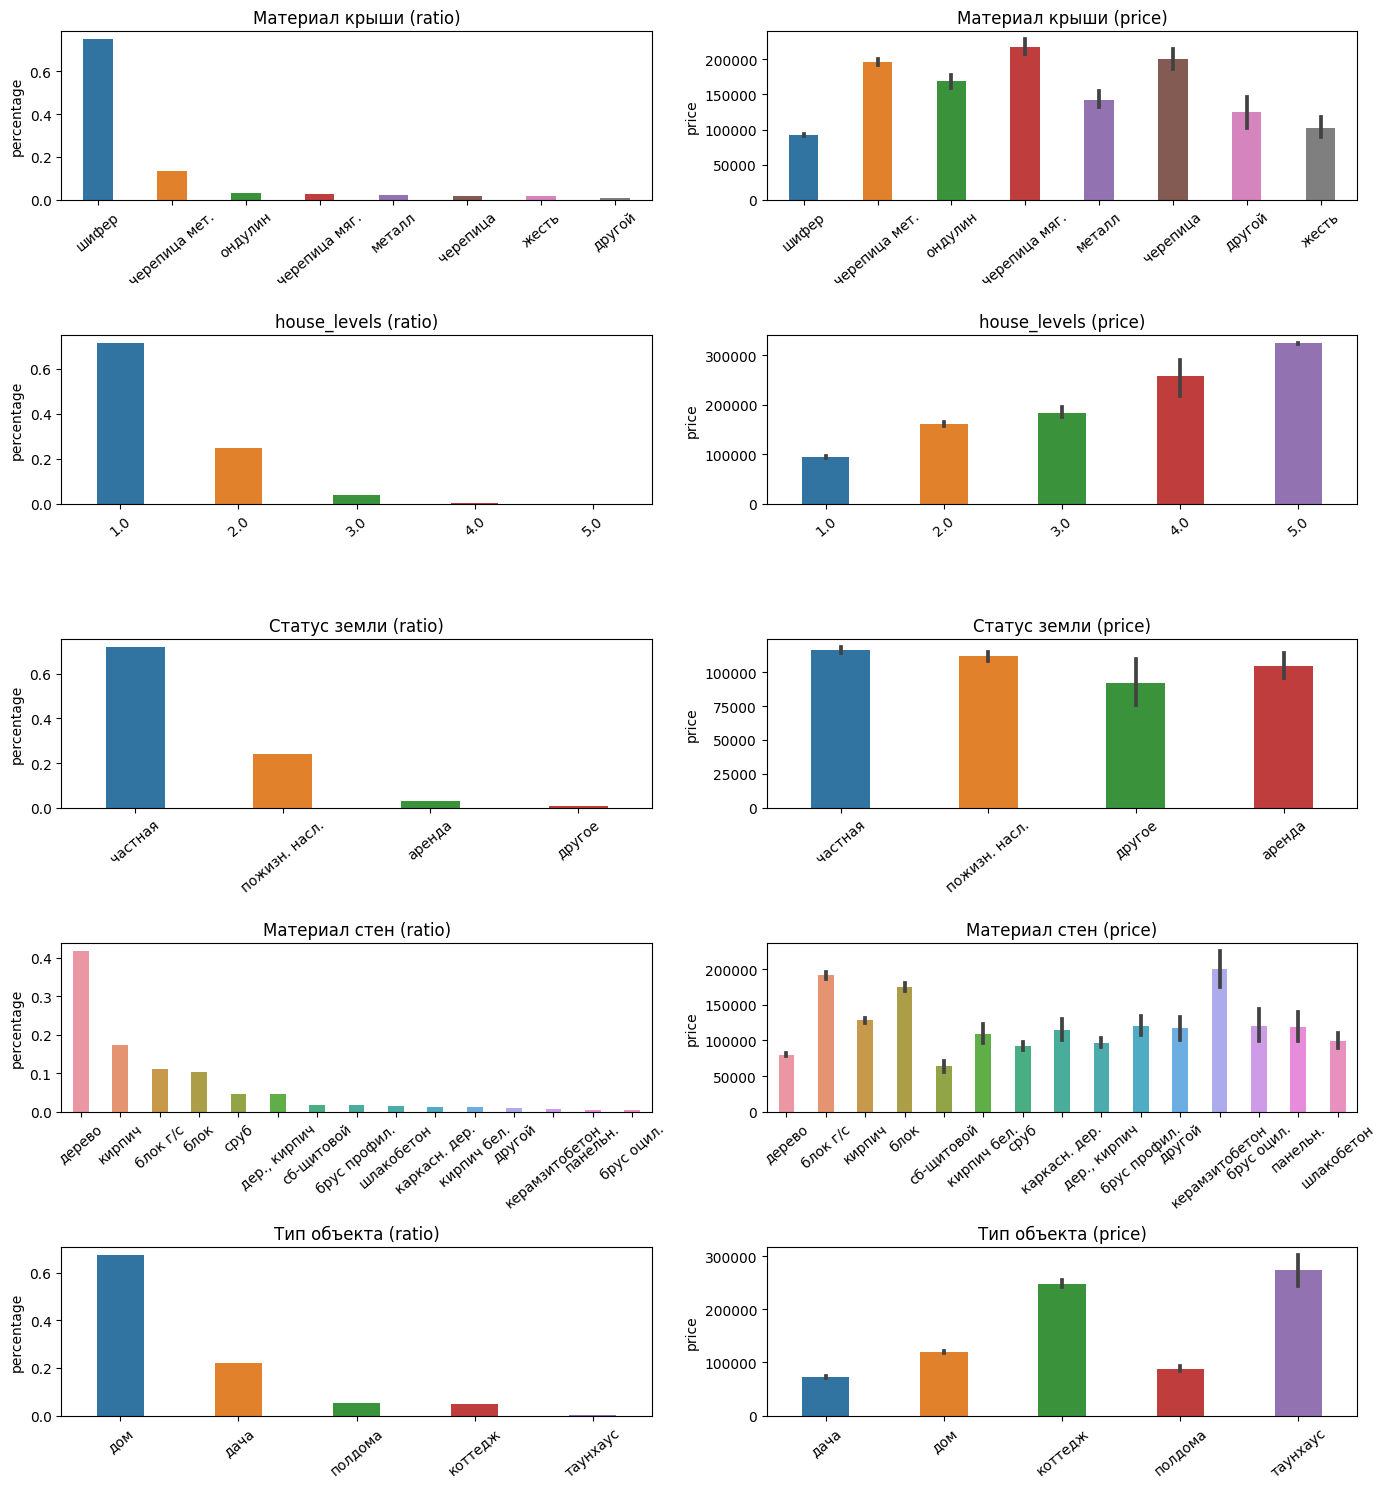

In [28]:
draw_categories(df,['Материал крыши', 'house_levels','Статус земли','Материал стен','Тип объекта'], 14, 40)

### Multi options categories. Manage to fill NAN

In [29]:
fill_na_manage

['Направление',
 'Сельсовет',
 'Район',
 'Область',
 'house_year',
 'Населенный пункт']

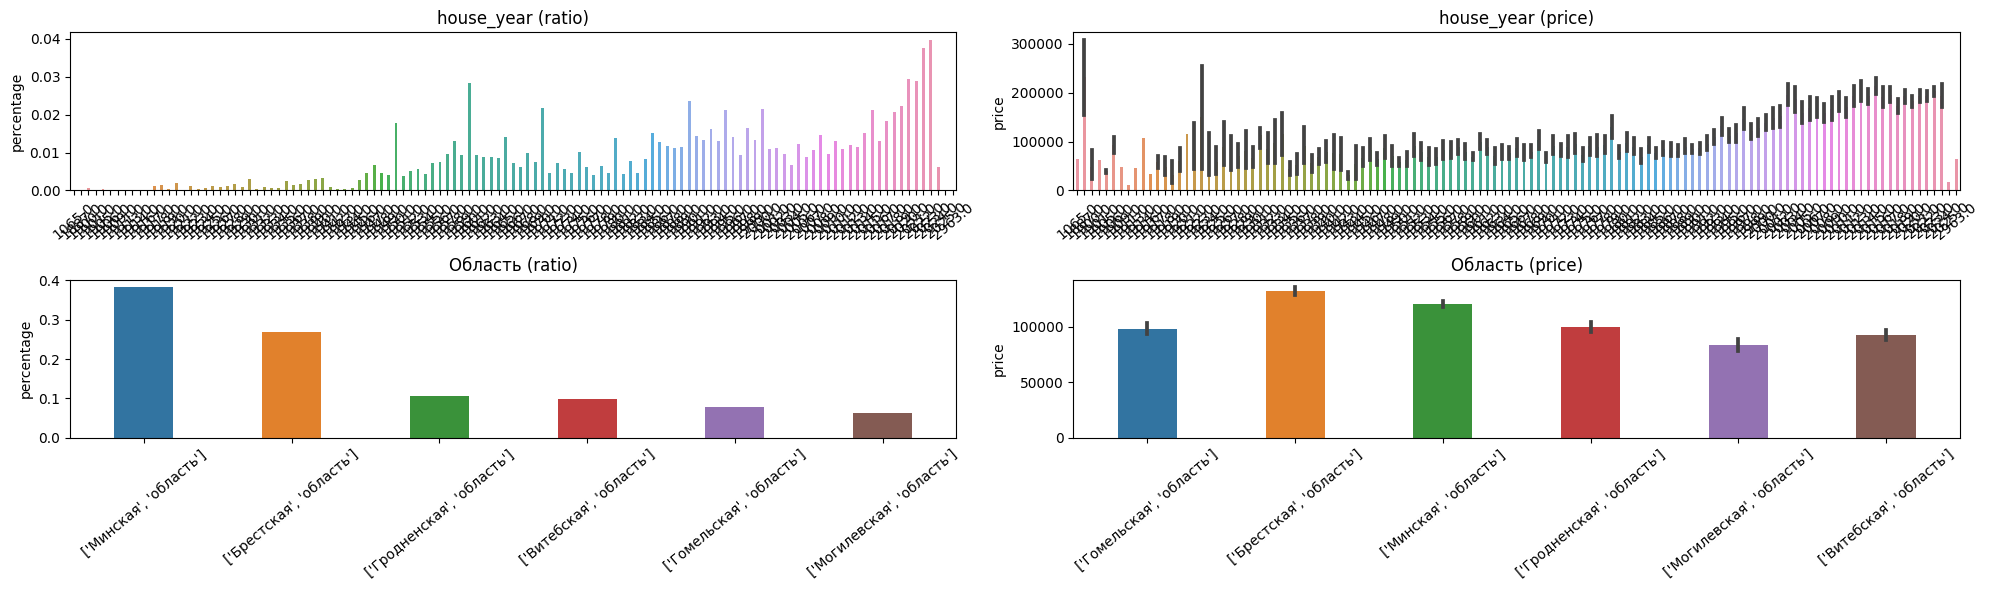

In [30]:
draw_categories(df,['house_year', 'Область'],20,40)

In [31]:
class CAT_3_Transformer(TransformerMixin, BaseEstimator):
    '''Transform categories with multiple values, supposed to be managed before fillna '''

    def __init__(self, fillna_cats):
        self.categories = fillna_cats
     
    def fit(self, X, y=None):
        ''''''
        return self

    def transform(self,X):
        ''''''
        X['Направление'] = X['Направление'].apply(
            lambda x: re.findall(r'\'(\w{5,})\,.', x)[0] if x is not np.nan else x)
        X['Направление'] = X['Направление'].fillna('unknown')
        X['in_city'] = X['Населенный пункт'].apply(
            lambda x: 1 if len(re.findall(r'\'([г]{1}\.)\'', x))==1 else 0)
        X['Населенный пункт'] = X['Населенный пункт'].apply(
            lambda x: (' ').join(re.findall(r'\'([А-Яа-я0-9]{1,})\'', x.replace('-','').replace('/','').replace('.',''))))
        
        #X['house_year'] = df['house_year'].fillna(df.groupby('Населенный пункт')['house_year'].transform(lambda x: x.mode()[0] if len(x.mode())>0 else np.nan))
        #X['house_year'] = df['house_year'].fillna(df['house_year'].mode()[0])
        #X = X[(X['house_year']>1900) & (X['house_year']<2025)]
        X = X[~((X['house_year']<1950) & (X['price']>2*X['price'].median()))]
        X['year_group'] = pd.cut(
            X.house_year, [0,1900,1920,1940,1960,1980,2000,9999], 
            labels = ['<1900','1900-1920','1920-1940','1940-1960','1960-1980','1980-2000','2000+']) 
        X['year_group'] = X['year_group'].fillna(X['year_group'].mode()[0])


        X['Область'] = X['Область'].map({
            "['Гомельская', 'область']":'Гомель', 
            "['Минская', 'область']":'Минск', 
            "['Гродненская', 'область']":'Гродно', 
            "['Брестская', 'область']":'Брест',
            "['Могилевская', 'область']":'Могилев',
            "['Витебская', 'область']":'Витебск'
            })
        
        X['Район'] = X['Район'].apply(
            lambda x: re.findall(r'\'([А-Яа-я.]{1,})\'',x.replace('-',''))[0] if x is not np.nan else x)
        X.loc[X[X['Населенный пункт']=="г Минск"].index,'Район'] = 'Минск'
        X = X[X['Район'].notna()]
                
        #df_district = pd.read_csv('data/districts.csv').rename(columns={'Unnamed: 0':'Район'})
        #X = pd.merge(X, df_district, how='left', on='Район')

        #largest_districts = X['Район'].value_counts().nlargest(30).index
        #X['Район'] = X['Район'].apply(lambda x: x if x in largest_districts else 'другой')
        
        largest_towns = X['Населенный пункт'].value_counts().nlargest(20).index
        X['Населенный пункт'] = X['Населенный пункт'].apply(lambda x: x if x in largest_towns else 'другой')
        
        X.drop(['house_year', 'Сельсовет'], axis=1, inplace=True)
                
        print(f"DF shape after CAT_3_Transformer {X.shape}")

        return X
    

cat_3_treat = CAT_3_Transformer(fill_na_manage)
df = cat_3_treat.transform(df)

DF shape after CAT_3_Transformer (12978, 39)


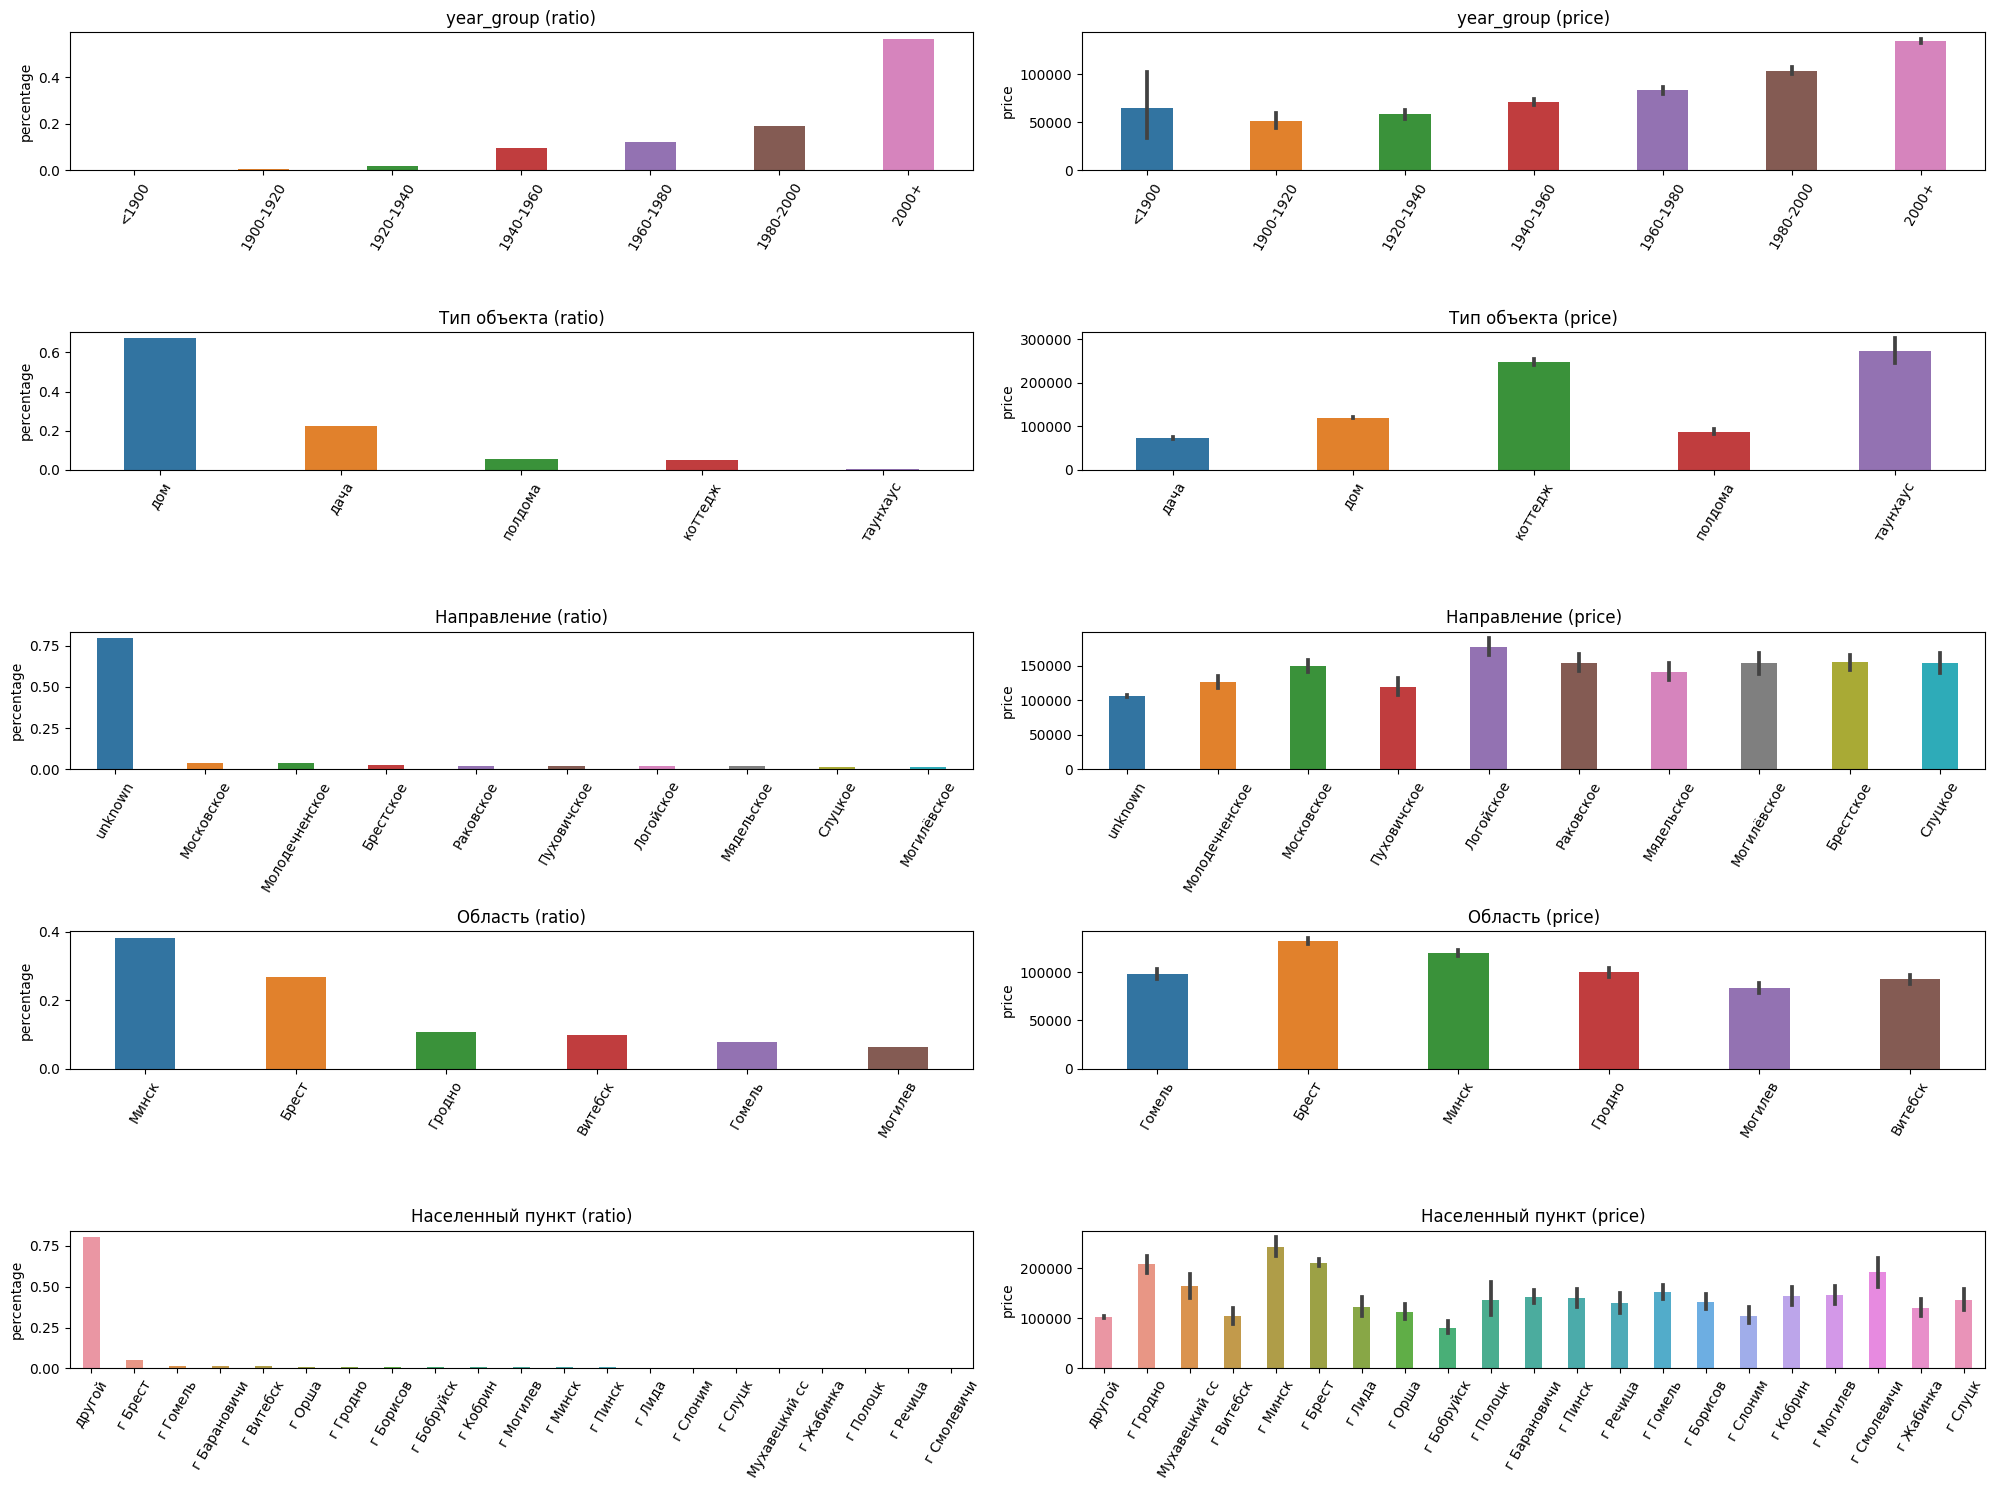

In [32]:
draw_categories(df,['year_group', 'Тип объекта','Направление', 'Область', 'Населенный пункт'],20,60)

### New features

In [33]:
district_dict = dict()


#for i in df['Район'].unique():
#    try:
#        district_dict[i] = get_district_details(i + ' район, Беларусь')
#    except:
#        print(i, "couldn't get data")
#        continue

#district_dict['Славгородский'] = [(53.2643, 30.5947), (53.2643, 30.5947)]

#df_district = pd.DataFrame(district_dict, index=['district_center_coordinates', 'district_city_coordinates']).T
#df_district.to_csv('data/districts.csv')

In [34]:
class NEW_4_Transformer(TransformerMixin, BaseEstimator):
    '''Transform categories with multiple values, supposed to be managed before fillna '''

    def __init__(self):
        pass
     
    def fit(self, X, y=None):
        ''''''
        return self

    def transform(self,X):
        ''''''
        #
        regions_dict = dict()
        regions = df['Область'].unique()

        for item in regions:
            if type(item) is str:
                regions_dict[item] = get_location(item + ', беларусь')
            else:
                continue


        X['regional_center_coordinates'] = X['Область'].apply(lambda x: str(regions_dict[x]) )

        #
        districts_df = pd.read_csv('data/districts.csv').rename(columns={'Unnamed: 0':'Район'})
        districts_df.loc[districts_df.shape[0]] = ['Минск','(53.55, 27.33)','(53.55, 27.33)']
        X = pd.merge(X, districts_df, how='left', on='Район')
        
        #df['distance_house_district_center'] = df.apply(lambda x: get_distance(x['house_coordinates'], x['district_center_coordinates']), axis=1)
        X['distance_house_district_city'] = X.apply(lambda x: get_distance(X,x['house_coordinates'], x['district_city_coordinates'], regions_dict), axis=1)
        #df['distance_house_region'] = df.apply(lambda x: get_distance(x['house_coordinates'], x['regional_center_coordinates'],1)[0], axis=1)
        X['distance_house_region_min'] = X.apply(lambda x: get_distance(X,x['house_coordinates'], x['regional_center_coordinates'],regions_dict,1)[1], axis=1)
        X['distance_house_minsk'] = X.apply(lambda x: get_distance(X,x['house_coordinates'], str(regions_dict['Минск']),regions_dict), axis=1)
        X['distances_multiply'] = X['distance_house_minsk'] * X['distance_house_region_min'] * X['distance_house_district_city']
        X['distances_sum'] = X['distance_house_minsk'] + X['distance_house_region_min'] + X['distance_house_district_city']

        largest_districts = X['Район'].value_counts().nlargest(30).index
        X['Район'] = X['Район'].apply(lambda x: x if x in largest_districts else 'другой')

        print(f"DF shape after NEW_4_Transformer {X.shape}")

        return X
    

cat_4_treat = NEW_4_Transformer()
df = cat_4_treat.transform(df)


DF shape after NEW_4_Transformer (12978, 47)


count     12978.000000
mean     114300.018108
std       97450.863529
min        1188.000000
25%       38905.000000
50%       81053.000000
75%      162750.000000
max      398778.000000
Name: price, dtype: float64

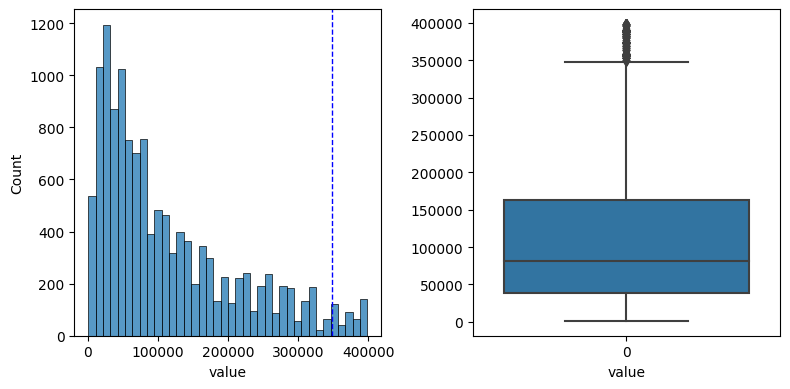

In [35]:
f,a = plt.subplots(1,2,figsize=(8,4))
x = df['price']
sns.histplot(x, ax=a[0]).set(title=f'', xlabel='value');
sns.boxplot(x, ax=a[1]).set(title=f'', xlabel='value');
a[0].axvline(x.quantile(0.75) + 1.5*(x.quantile(0.75)-x.quantile(0.25)), color='b', ls='--', lw=1)
plt.tight_layout()
x.describe()

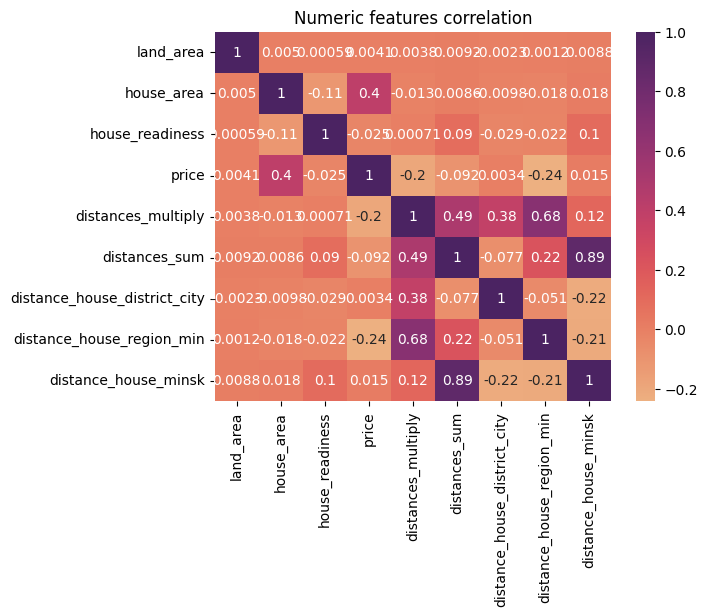

In [36]:
sns.heatmap(
    df.loc[:,num_features+['distances_multiply','distances_sum','distance_house_district_city','distance_house_region_min','distance_house_minsk']].corr(), 
    cmap='flare', 
    annot=True).set(title='Numeric features correlation');

### Handling outliers

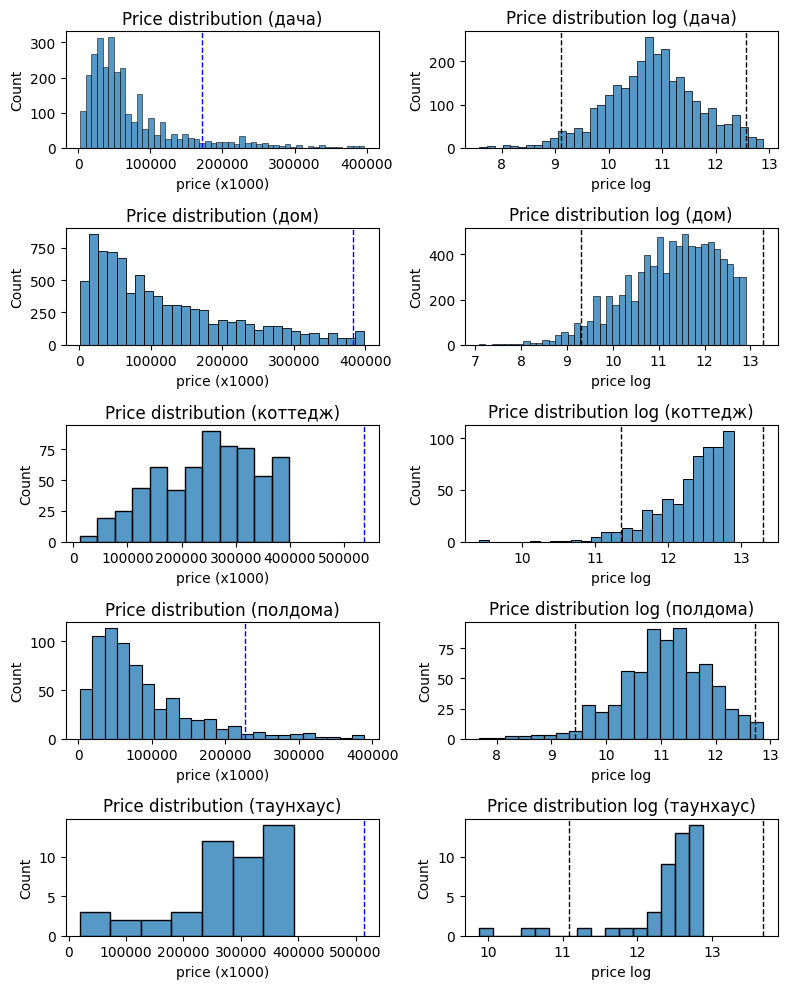

In [37]:
temp = df['Тип объекта'].unique()
f,a = plt.subplots(len(temp),2, figsize=(8,2*len(temp)))
for i,k in enumerate(temp):
    x = df[df['Тип объекта']==k]['price']
    sns.histplot(x, ax=a[i,0]).set(title=f'Price distribution ({k})', xlabel='price (x1000)');
    #a[i,0].axvline(x.mean(), color='r', lw=1)
    #a[i,0].axvline(x.quantile(0.25) - 1.5*(x.quantile(0.75)-x.quantile(0.25)), color='b', ls='--', lw=1)
    a[i,0].axvline(x.quantile(0.75) + 1.5*(x.quantile(0.75)-x.quantile(0.25)), color='b', ls='--', lw=1)
    
    sns.histplot(np.log(df[df['Тип объекта']==k]['price']), ax=a[i,1]).set(title=f'Price distribution log ({k})', xlabel='price log');
    #a[i,1].axvline(x.median(), color='k', lw=1)
    a[i,1].axvline(np.log(x).mean()+ 2 * np.log(x).std(), color='k', ls='--', lw=1)
    a[i,1].axvline(np.log(x).mean()- 2 * np.log(x).std(), color='k', ls='--', lw=1)

plt.tight_layout()

In [38]:
print(f"DF shape before outliers removing: {df.shape}")
df_cleaned = pd.DataFrame()
for i in df['Тип объекта'].unique():
    df_cleaned = pd.concat([df_cleaned, outliers_iqr_mod(df[df['Тип объекта']==i], 'price', right=1.5,log_scale=False)], axis=0)
    #df_cleaned = pd.concat([df_cleaned, outliers_z_score(df[df['Тип объекта']==i], 'price', right=2.0,left=2.0,log_scale=True)], axis=0)
    #print(f"DF shape after cleaning outliers from object {i}: {df_cleaned.shape}")

print(f"DF shape after outliers removing: {df_cleaned.shape}")

DF shape before outliers removing: (12978, 47)
DF shape after outliers removing: (12539, 47)


In [39]:
ohe_list = ['Материал стен', 'Материал крыши', 'Отопление', 'Канализация', 'Электроснабжение', 
           'Вода','Область',  'Газ',  'Ремонт', 'Район','year_group', 'Тип объекта', 'Населенный пункт']#'Статус земли', 'Направление', 

encoder = ce.OneHotEncoder(cols=ohe_list, use_cat_names=True)
oh_data = encoder.fit_transform(df_cleaned.loc[:,ohe_list])
dff = pd.concat([df_cleaned,oh_data], axis=1).drop(ohe_list, axis=1)

dff = dff.drop(['house_coordinates','regional_center_coordinates',  'Статус земли', 
                'Направление', 'district_center_coordinates','district_city_coordinates'], axis=1)
#dff = dff.drop(['distances_sum','distance_house_district_city','distance_house_region_min','distance_house_minsk'], axis=1) # 'distances_multiply',

dff.shape

(12539, 154)

### Models

In [40]:
logger.info(f"price<400000")

In [41]:
X = dff.drop('price', axis=1)
y = dff['price']
col_names = X.columns



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
y_train_log = np.log(y_train)

scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


X_train_df = pd.DataFrame(X_train, columns=col_names)
X_test_df = pd.DataFrame(X_test, columns=col_names)
print(f'Train shape: {X_train.shape}')
print(f'Test shape: {X_test.shape}')


X_train_df.head()


Train shape: (10031, 153)
Test shape: (2508, 153)


,Телефон,Баня,Гараж,Сад,Хозпостройки,Рядом лес,Водоем,Ландшафтный дизайн,Теплица,Мебель,...,Населенный пункт_г Пинск,Населенный пункт_г Речица,Населенный пункт_г Гомель,Населенный пункт_г Борисов,Населенный пункт_г Кобрин,Населенный пункт_г Слоним,Населенный пункт_г Смолевичи,Населенный пункт_г Жабинка,Населенный пункт_г Могилев,Населенный пункт_г Слуцк
8725,0,0,1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
892,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11376,0,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8759,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7586,1,0,1,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
indx_dacha = X_test_df[X_test['Тип объекта_дача']==1].index
print(f"indx with 'Тип объекта дача' {len(indx_dacha)}")
X_test_dacha = X_test_df.loc[indx_dacha]
y_test_dacha = y.loc[indx_dacha]

indx with 'Тип объекта дача' 518


In [43]:
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
y_test_pred_dacha = lr.predict(X_test_dacha)

errs = get_metrics(y_train, y_train_pred, y_test, y_test_pred, y_test_dacha, y_test_pred_dacha)
display(errs)
logger.info(f"______lr | r2:{errs['r2'].values}, mae: {errs['mae'].values}")

,r2,mae
TRAIN,0.68,38130.27
TEST,0.67,38722.86
TEST_dacha,0.17,25689.66


In [44]:
params = {"n_estimators":2**np.arange(8), 
          "max_depth":np.arange(1,4),
          "learning_rate":0.1**np.arange(3)
          }

gs = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=33), 
    param_grid=params,
    scoring='neg_root_mean_squared_error', #make_scorer(f1_score)
    cv=3, 
    n_jobs = -1
)  

gs.fit(X_train, y_train) 
#gs.fit(X_train, y_train_log) 

y_train_pred = gs.predict(X_train)
y_test_pred = gs.predict(X_test)
y_test_pred_dacha = gs.predict(X_test_dacha)
#y_train_pred = np.exp(gs.predict(X_train))
#y_test_pred = np.exp(gs.predict(X_test))


errs = get_metrics(y_train, y_train_pred, y_test, y_test_pred, y_test_dacha, y_test_pred_dacha)
display(errs)
logger.info(f"______gs | r2:{errs['r2'].values}, mae: {errs['mae'].values}")

,r2,mae
TRAIN,0.76,31734.68
TEST,0.73,33647.18
TEST_dacha,0.56,17972.22


In [45]:
def optuna_rf(trial):
    """_summary_

    Args:
        trial (_type_): _description_

    Returns:
        _type_: _description_
    """
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 1, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=33
        )
  
    model.fit(X_train, y_train)
    #score = metrics.r2_score(y_train_log, model.predict(X_train_scaled))
    score_test = metrics.r2_score(y_test, model.predict(X_test))
    score_train = metrics.r2_score(y_train, model.predict(X_train))
    score = score_test / (score_train-score_test)

    return score


study = optuna.create_study(study_name="RandomForestRegressor", direction="maximize")
study.optimize(optuna_rf, n_trials=20)

print(f"Best hyperparameters {study.best_params}")
print(f"Best score: {study.best_value}")

#--> Best hyperparameters {'n_estimators': 129, 'max_depth': 25, 'min_samples_leaf': 10}

[I 2024-04-30 21:28:21,577] A new study created in memory with name: RandomForestRegressor
[I 2024-04-30 21:28:26,083] Trial 0 finished with value: 41.3421489323278 and parameters: {'n_estimators': 131, 'max_depth': 5, 'min_samples_leaf': 3}. Best is trial 0 with value: 41.3421489323278.
[I 2024-04-30 21:28:35,191] Trial 1 finished with value: 5.331303965107943 and parameters: {'n_estimators': 118, 'max_depth': 22, 'min_samples_leaf': 7}. Best is trial 0 with value: 41.3421489323278.
[I 2024-04-30 21:28:37,865] Trial 2 finished with value: -123.39865614192675 and parameters: {'n_estimators': 133, 'max_depth': 3, 'min_samples_leaf': 5}. Best is trial 0 with value: 41.3421489323278.
[I 2024-04-30 21:28:50,108] Trial 3 finished with value: 4.130609721186384 and parameters: {'n_estimators': 166, 'max_depth': 13, 'min_samples_leaf': 3}. Best is trial 0 with value: 41.3421489323278.
[I 2024-04-30 21:29:00,564] Trial 4 finished with value: 4.8585207979463645 and parameters: {'n_estimators': 1

Best hyperparameters {'n_estimators': 133, 'max_depth': 4, 'min_samples_leaf': 4}
r2-score for TRAIN set: 270.1834679318882


In [46]:
rfr = RandomForestRegressor(**study.best_params,random_state=33)
#rfr = RandomForestRegressor(n_estimators= 129, max_depth = 25, min_samples_leaf = 10,random_state=33)

rfr.fit(X_train, y_train)

y_train_pred = rfr.predict(X_train)
y_test_pred = rfr.predict(X_test)
y_test_pred_dacha = rfr.predict(X_test_dacha)

errs = get_metrics(y_train, y_train_pred, y_test, y_test_pred, y_test_dacha, y_test_pred_dacha)
display(errs)
logger.info(f"_____rfr | r2:{errs['r2'].values}, mae: {errs['mae'].values}")

,r2,mae
TRAIN,0.59,43012.90
TEST,0.59,43519.13
TEST_dacha,0.15,26676.19


In [47]:
imp_df = pd.DataFrame({'index': X_train.columns, 'importance':rfr.feature_importances_}).sort_values(by='importance', ascending=False).nlargest(columns='importance',n=15)
imp_df#.nlargest(50)

,index,importance
18,house_area,0.663603
53,Отопление_паровое г.,0.138536
25,distances_multiply,0.080581
42,Материал крыши_шифер,0.028744
23,distance_house_region_min,0.024763
127,Тип объекта_дача,0.018485
50,Отопление_печь,0.010601
128,Тип объекта_дом,0.005654
52,Отопление_электрич.,0.005285
129,Тип объекта_коттедж,0.004125


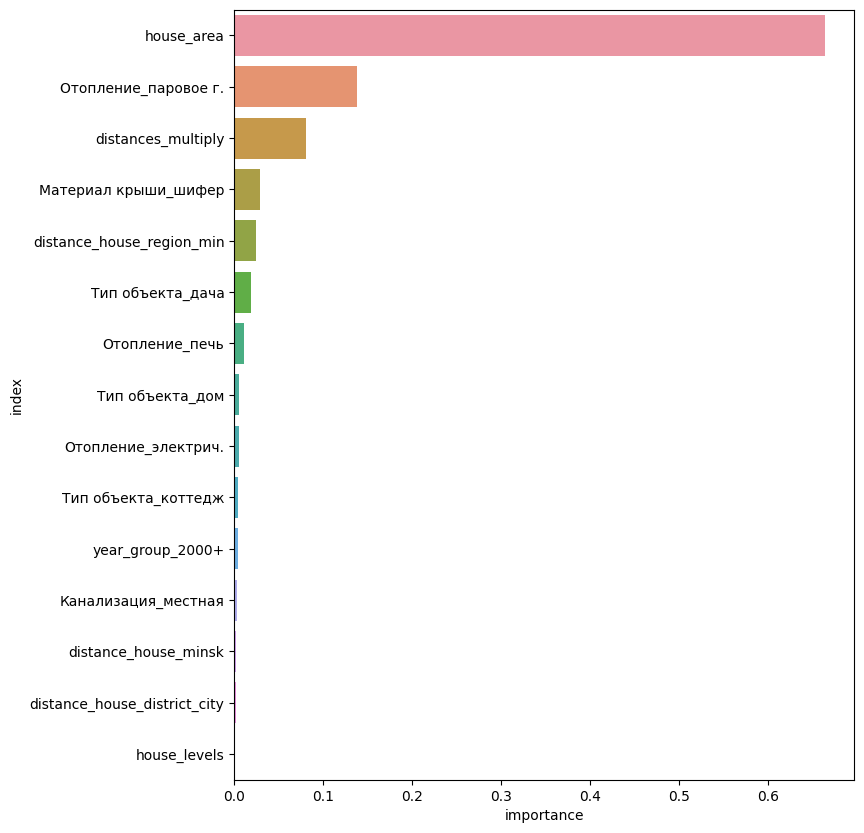

In [48]:
f,a = plt.subplots(figsize=(8,10))
sns.barplot(y=imp_df['index'], x=imp_df.importance, orient='h');

In [49]:
params = {"n_estimators":2**np.arange(8), 
          "max_depth":np.arange(1,4),
          "learning_rate":0.1**np.arange(3)
          }

gs = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=33), 
    param_grid=params,
    scoring='neg_root_mean_squared_error', #make_scorer(f1_score)
    cv=3, 
    n_jobs = -1
)  

gs.fit(X_train[imp_df['index'].values[:20]], y_train) 
#gs.fit(X_train[imp_df['index'].values[:20]], y_train_log) 

y_train_pred = gs.predict(X_train[imp_df['index'].values[:20]])
y_test_pred = gs.predict(X_test[imp_df['index'].values[:20]])
y_test_pred_dacha = gs.predict(X_test_dacha[imp_df['index'].values[:20]])
#y_train_pred = np.exp(gs.predict(X_train[imp_df['index'].values[:20]]))
#y_test_pred = np.exp(gs.predict(X_test[imp_df['index'].values[:20]]))


errs = get_metrics(y_train, y_train_pred, y_test, y_test_pred, y_test_dacha, y_test_pred_dacha)
display(errs)
logger.info(f"__gs_imp | r2:{errs['r2'].values}, mae: {errs['mae'].values}")

,r2,mae
TRAIN,0.72,34513.81
TEST,0.69,36534.06
TEST_dacha,0.51,19148.96


In [50]:
train_scores_r2 = []
test_scores_r2 = []
train_scores_mae = []
test_scores_mae = []

for i in np.arange(20, X_train.shape[1],20):
    selector = SelectKBest(f_regression, k=i)
    selector.fit(X_train, y_train)
    best_fea = selector.get_feature_names_out()

    params = {"n_estimators":2**np.arange(8), 
          "max_depth":np.arange(1,4),
          "learning_rate":0.1**np.arange(3)
          }

    gs = GridSearchCV(
        estimator=GradientBoostingRegressor(random_state=33), 
        param_grid=params,
        scoring='neg_root_mean_squared_error', #make_scorer(f1_score)
        cv=3, 
        n_jobs = -1
    )  

    gs.fit(X_train_df[best_fea], y_train) 
    #gs.fit(X_train_df[best_fea], y_train_log) 

    y_train_pred = gs.predict(X_train_df[best_fea])
    y_test_pred = gs.predict(X_test_df[best_fea])
    
    
    #y_train_pred = np.exp(gs.predict(X_train_df[best_fea]))
    #y_test_pred = np.exp(gs.predict(X_test_df[best_fea]))

    train_scores_r2.append(metrics.r2_score(y_train, y_train_pred))
    test_scores_r2.append(metrics.r2_score(y_test, y_test_pred))
    train_scores_mae.append(metrics.mean_absolute_error(y_train, y_train_pred))
    test_scores_mae.append(metrics.mean_absolute_error(y_test, y_test_pred))
    #metrics.mean_absolute_error(y_test, y_test_pred)


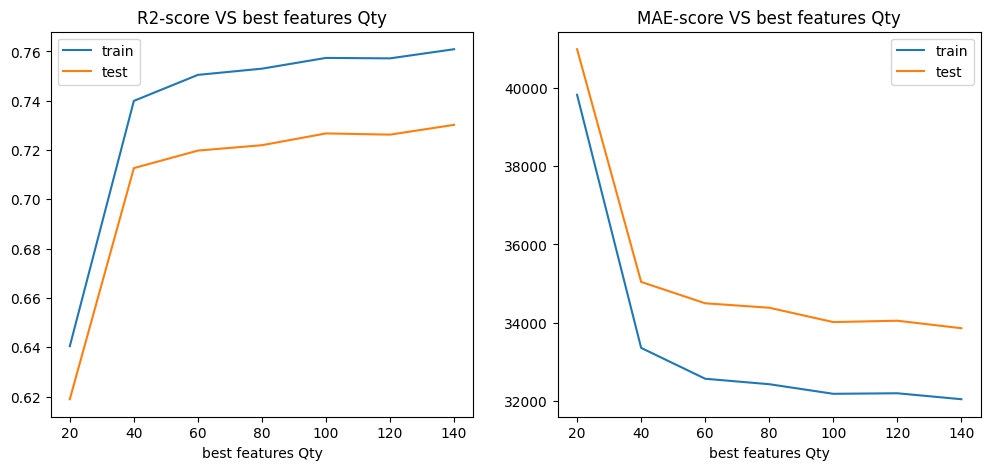

In [51]:
f,a = plt.subplots(1,2,figsize=(12,5))
sns.lineplot(x=np.arange(20, X_train.shape[1],20),y=train_scores_r2, ax=a[0], label='train').set(title='R2-score VS best features Qty', xlabel='best features Qty');
sns.lineplot(x=np.arange(20, X_train.shape[1],20),y=test_scores_r2, ax=a[0], label='test');
sns.lineplot(x=np.arange(20, X_train.shape[1],20),y=train_scores_mae, ax=a[1], label='train').set(title='MAE-score VS best features Qty', xlabel='best features Qty');
sns.lineplot(x=np.arange(20, X_train.shape[1],20),y=test_scores_mae, ax=a[1], label='test');

In [52]:
n = 40
selector = SelectKBest(f_regression, k=n)
selector.fit(X_train, y_train)
 
best_fea = selector.get_feature_names_out()
best_fea

array(['Гараж', 'Новостройка', 'Элитный коттедж', 'house_area',
       'house_levels', 'in_city', 'distance_house_region_min',
       'distances_multiply', 'Материал стен_дерево',
       'Материал стен_блок г/с', 'Материал стен_блок',
       'Материал крыши_шифер', 'Материал крыши_черепица мет.',
       'Материал крыши_черепица мяг.', 'Отопление_печь',
       'Отопление_электрич.', 'Отопление_паровое г.',
       'Канализация_местная', 'Канализация_нет',
       'Канализация_с/у наружн.', 'Канализация_центральн.',
       'Вода_сезонная', 'Вода_водопровод', 'Вода_колодец',
       'Вода_рядом колодец', 'Газ_нет', 'Газ_есть', 'Ремонт_отделка дер.',
       'Ремонт_евроотделка', 'Район_Брестский', 'Район_другой',
       'Район_Минский', 'year_group_1940-1960', 'year_group_2000+',
       'Тип объекта_дача', 'Тип объекта_дом', 'Тип объекта_коттедж',
       'Тип объекта_таунхаус', 'Населенный пункт_другой',
       'Населенный пункт_г Брест'], dtype=object)

In [53]:
params = {"n_estimators":2**np.arange(8), 
          "max_depth":np.arange(1,4),
          "learning_rate":0.1**np.arange(3)
          }

gs = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=33), 
    param_grid=params,
    scoring='neg_root_mean_squared_error', #make_scorer(f1_score)
    cv=3, 
    n_jobs = -1
)  

gs.fit(X_train[best_fea], y_train) 
#gs.fit(X_train[best_fea], y_train_log) 

y_train_pred = gs.predict(X_train[best_fea])
y_test_pred = gs.predict(X_test[best_fea])
#y_train_pred = np.exp(gs.predict(X_train[best_fea]))
#y_test_pred = np.exp(gs.predict(X_test[best_fea]))


errs = get_metrics(y_train, y_train_pred, y_test, y_test_pred, y_test_dacha, y_test_pred_dacha)
display(errs)
logger.info(f"gs_kbest | r2:{errs['r2'].values}, mae: {errs['mae'].values}, n_best={n}")

,r2,mae
TRAIN,0.74,33352.68
TEST,0.71,35041.26
TEST_dacha,0.51,19148.96


In [54]:
with open('model.pkl', 'wb') as output:
    pickle.dump(gs, output)

with open('model.pkl', 'rb') as pkl_file:
    model = pickle.load(pkl_file)

model

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=33),
             n_jobs=-1,
             param_grid={'learning_rate': array([1.  , 0.1 , 0.01]),
                         'max_depth': array([1, 2, 3]),
                         'n_estimators': array([  1,   2,   4,   8,  16,  32,  64, 128])},
             scoring='neg_root_mean_squared_error')